In [5]:
import numpy as np
from random import random
from tqdm import tqdm
import ray
import matplotlib.pyplot as plt
ray.init()

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

Want to sample from three variables:
1. $\lambda$
2. $\tau$
3. $\beta$

-> these values are then averaged to get the Monte-Carlo estimator
-> first: what is density of $\beta$?

In [20]:
# import data from DNN training
extracted_coefficients_directory = '../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)
tBB = B_zeta.T.dot(B_zeta)

In [21]:
beta = np.repeat(0,10)
# number of samples we want to produce
M = 50000+ 1
L = 77

# number of parameters of theta
q = 2*B_zeta.shape[1] + 1
p = B_zeta.shape[1]

n = B_zeta.shape[0]

# start values for beta, lambda, tau
# beta is taken from trained network and other two
# are initialized randomly
theta_m_1 = np.zeros(q)

# stepsize
epsilon = 0.00007

r_m = np.append(np.zeros(p), np.append(np.repeat(-6,p), 0))

tau_start = theta_m_1[q-1]

In [22]:
Lambda = np.repeat(1,p)
BoB = B_zeta**2

In [23]:
@ray.remote
def delta_beta(z, S, B_zeta, Lambda, beta):
    return (B_zeta.T.dot(z*1/S) - (B_zeta.T).dot(B_zeta).dot(beta) - beta/(Lambda**2))
@ray.remote
def delta_1_log_tau(p, log_tau, Lambda):
    tau = np.exp(log_tau)
    tau2 = tau**2
    Lambda2 = Lambda**2
    return(- (p-1) - (2*tau2)/(1+tau2) + 2*np.sum((Lambda2/tau2)/(1+Lambda2/(tau2))))

def generate_dS2_ddS2_S2_S(Lambda, BoB):
    
    n, p = BoB.shape
    W = np.sum(BoB*(Lambda**2), axis = 1)
    S2 = (1/(1 + W))
    S = np.sqrt(S2)
    
    dS2, ddS2 = np.zeros((n,p)), np.zeros((n,p))
    #for lj in range(0, p):
    #    dS2[:,lj] = - BoB[:,lj]*Lambda2[lj]/((1+W)**2)
    #    ddS2[:,lj] = (-BoB[:,lj]*Lambda2[lj] + (BoB[:,lj]*(Lambda2[lj]**2)))/((1+W)**3)
    
    #dS2 = - (BoB.dot(np.diag(Lambda2)))/(((1+np.tile(W, [p,1]))**2).T)
    #dS2 = 0
    return(dS2, S2, S)

@ray.remote
def delta_1_lambda(Lambda, beta, B_zeta, dS2, S2, S, z, tau):
    p = len(Lambda)
    Lambda2 = Lambda**2
    tau2 = tau**2
    dlogFucj = np.zeros(p)
    #for lj in range(0,p):
    #    dlogFucj[lj] = 0.5*(beta[lj]**2)/Lambda2[lj] - (Lambda2[lj]/tau2)/(1 + Lambda2[lj]/tau2) - 0.5*np.sum(dS2[:,lj]/S2) - 0.5*np.sum((z*z*(-dS2[:,lj]/(S2**2)))) + np.sum( beta.dot(B_zeta.T).dot(np.diag(-0.5*(dS2[:,lj]/(S2**(1.5))))).dot(z))  
    for lj in range(0, len(Lambda)):             
        dlogFucj[lj] = (0.5*(beta[lj]**2)/Lambda2[lj]
                         - (Lambda2[lj]/tau2)/(1 + Lambda2[lj]/tau2)
                         + 0.5
                         + 0.5*np.sum((B_zeta[:,lj]**2)*Lambda2[lj]*S2)
                         - 0.5*np.sum((z**2)*(B_zeta[:,lj]**2)*Lambda2[lj])
                        + 0.5*(beta.T.dot(B_zeta.T)*S*(B_zeta[:,lj]**2)*(Lambda2[lj])).dot(z))
                         #+ 0.5*(beta.T.dot(B_zeta.T)*S*W).dot(z))
    
    #dlogFucj = (0.5*(beta**2)/Lambda2 - (Lambda2/tau2)/(1 + Lambda2/tau2) + 0.5 + 
    #            # old: 0.5*np.sum((B_zeta**2)*np.tile(S2, [p,1]).T*Lambda2, axis = 0) 
    #            0.5*np.array([(B_zeta[:,i]**2).dot(S2*(Lambda[i]**2)) for i in range(0, B_zeta.shape[1])])
    #            - 0.5*(z**2).dot((B_zeta**2))*Lambda2
                #old :+  0.5*((((np.tile(B_zeta.dot(beta), [p,1]).T)*(B_zeta**2)*Lambda2)*np.tile(S, [p,1]).T).T).dot(z))
    #            + np.array([(B_zeta.dot(beta)*((B_zeta[:,i]**2)*Lambda[i]**2)).dot(S*z) for i in range(0, B_zeta.shape[1])]))
    
    
    
               # + 0.5*np.sum(((B_zeta**2)*np.tile(S2, [p,1]).T)*Lambda2) - 0.5*(z**2).dot((B_zeta**2)*Lambda2) 
            #+ ((((np.tile(B_zeta.dot(beta), [p,1]).T)*(B_zeta**2)*Lambda2)*np.tile(S, [p,1]).T).T).dot(z))
               # - 0.5*np.sum(dS2/(np.tile(S2.T, [p,1]).T), axis = 0) - 
               #0.5*np.sum((np.tile(z*z, [p,1]).T*(-dS2/np.tile((S2**2), [p,1]).T)), axis = 0) + 
               #(beta*((B_zeta*(-0.5)*(dS2/np.tile(S2**1.5, [p,1]).T)).T).dot(z))) 
    return(dlogFucj)

def Delta_theta(vartheta_t, B, n, z, p, tBB, betaBt, BoB):
    vartheta_new = vartheta_t.copy()
    beta_t = vartheta_new[0:p].reshape(p,)
    Lambda_t = np.exp(0.5*vartheta_new[p:2*p])
    log_tau_t = vartheta_new[2*p]

    dS2,  S2, S = generate_dS2_ddS2_S2_S(Lambda_t, BoB)
    
    # Gradient w.r.t. beta
    #grad_beta = delta_beta(z, S, B, Lambda_t, beta_t)
    
    #grad_lambda = delta_1_lambda(Lambda_t, beta_t, B, dS2, ddS2, S2, S, z, np.exp(log_tau_t))
    # Gradient w.r.t. tau
    #grad_tau = delta_1_log_tau(p, log_tau_t, Lambda_t)
    
    ret_id1 = delta_beta.remote(z, S, B, Lambda_t, beta_t)
    ret_id2 = delta_1_lambda.remote(Lambda_t, beta_t, B, dS2, S2, S, z, np.exp(log_tau_t))
    ret_id3 = delta_1_log_tau.remote(p, log_tau_t, Lambda_t)
    grad_beta, grad_lambda, grad_tau = ray.get([ret_id1, ret_id2, ret_id3])
    #print(grad_beta, grad_lambda, grad_tau)
    
    return(np.append(grad_beta, np.append(grad_lambda, grad_tau)))

def log_density(S, B, beta, Lambda, log_tau, z, p):
    Lambda2 = Lambda**2
    tau2 = np.exp(log_tau)**2
    S2 = S**2
    # old: square_term = (z - (B_zeta*np.tile(S, [p,1]).T).dot(beta))
    square_term = (z - (np.array([B[:,i]*(S[i]) for i in range(0, B.shape[1])]).T.dot(beta)))
    term1 = - 0.5*np.sum(np.log(S2))  #
    term2 = + 0.5*np.sum(np.log(Lambda2))  #
    term3 = - 0.5*((square_term/S2).dot(square_term)) #
    #term3 = B.dot(beta).dot(z/S) 
    #term4 = - 0.5*np.sum(z**2/S2)  
    term4 = -0.5*np.sum((beta**2)/(Lambda2)) #
    #term6 = - 0.5*np.sum(B.dot(beta)**2)  
    term5 = -(p-1)*log_tau #
    term6 = - np.sum(np.log(1+Lambda2/tau2))  
    term7 = - np.log(1 + tau2) #
    return(term1 + term2 + term3 + term4 + term5 + + term6 + term7 ) #+ term8 + term9

In [24]:
def Leapfrog(theta, r, epsilon, n, z, p, B, tBB, betaBt, i, L):
    
    # compute gradient with theta
    #Delta_theta_t = Delta_theta(theta, B, n, z, p, tBB, betaBt, BoB)

    # update momentum
    #r_tilde = r + (epsilon/2)*Delta_theta_t

    # update theta
    theta_tilde = (theta + epsilon*r).reshape(2*p + 1,)
    beta_t = theta_tilde[0:p]
    betaBt_t = beta_t.dot(B_zeta.T)
    
    # compute updated gradient
    Delta_theta_tilde = Delta_theta(theta_tilde, B, n, z, p, tBB, betaBt_t, BoB)
    
    # update momentum again
    #r_tilde = r_tilde + (epsilon/2)*Delta_theta_tilde
    
    if i != L:
        # update momentum again
        r_tilde = r + (epsilon)*Delta_theta_tilde # old = r + 0.5*epsilon*Delta_theta_tilde
    
    
    return(theta_tilde, r_tilde)

In [12]:
#theta_m_1 = np.load('../../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas_try.npy', allow_pickle=True).tolist()
#r_m = np.load('../../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/r_m_try.npy', allow_pickle=True).tolist()

In [172]:
#seed = 6835963
r0 = np.repeat(None, 30000)
theta_tilde = np.repeat(None, 30000)
r_tilde = np.repeat(None, 30000)
#log_dens = np.repeat(None, 30000)
#r_tilde = np.repeat(None, M)
log_dens =  np.repeat(None, 30000)
alpha = np.repeat(None, 30000)
#theta_m_1 = np.repeat(None, M)
#r_m = np.repeat(None, M)
#theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(0,p), 0))

acc = []
# loop over number of samples that we want to produce
#theta_tilde[0] = np.zeros(21)
#r_tilde[0] = np.zeros(21)
#theta_m_1[1] =  np.append(np.zeros(p), np.append(np.repeat(0,p), 0))
#all_thetas = []
#theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(0,p), 0))
#r_m[0] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
#r_m[1] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
for m in tqdm(range(20952, M)):
    
    # Update S
    # draw momentum from normal distribution
    r0[m] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
    
    # set new parameters
    theta_tilde[m] = np.array(theta_m_1[m]).reshape(q,)
    r_tilde[m] = r0[m]
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # compute gradient with theta
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, n, z, p, tBB, betaBt, BoB)

    # update momentum
    r_tilde[m] = r_tilde[m] + (epsilon*0.5)*Delta_theta_t
    
    # generate proposal through L leapfrog updates 
    for i in range(0,L):
        betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
        theta_tilde[m], r_tilde[m] = Leapfrog(theta_tilde[m], 
                                              r_tilde[m], 
                                              epsilon, n, z, p, 
                                              B_zeta, tBB, 
                                              betaBt, i, L)
        
    # compute gradient with theta
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, n, z, p, tBB, betaBt, BoB)

    # update momentum
    r_tilde[m] = r_tilde[m] + (epsilon*0.5)*Delta_theta_t
    
    dS2, S2, S =  generate_dS2_ddS2_S2_S(np.exp(0.5*theta_tilde[m][p:2*p]), BoB)
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # probability that proposal is accepted
    #log_dens[m] = log_density(S, B_zeta, theta_tilde[m][0:p], np.exp(0.5*theta_tilde[m][p:2*p]), theta_tilde[m][p], z, p)
    #alpha[m] = min([1, (np.exp(log_dens[m] - r_tilde[m].dot(r_tilde[m].T)*1/2))/np.exp((log_dens[m] - r0[m].dot(r0[m].T)*1/2))])
        # probability that proposal is accepted
    theta_m_1[m] = np.array(theta_m_1[m])
    log_dens[m] = log_density(S, B_zeta, theta_tilde[m][0:p], np.exp(0.5*theta_tilde[m][p:2*p]), theta_tilde[m][p], z, p)
    proposed_u = log_density(S, B_zeta, theta_m_1[m][0:p], np.exp(0.5*theta_m_1[m][p:2*p]), theta_m_1[m][p], z, p)
    current_K = r_tilde[m].dot(r_tilde[m].T)*0.5
    proposed_K = r_m[m].dot(r_m[m].T)*0.5
    p_accept = log_dens[m] -  proposed_u + current_K - proposed_K
    alpha[m] = np.exp(min([np.log(1), p_accept]))
    
    if np.random.randn() <= alpha[m]:
        theta_m_1[m + 1] = theta_tilde[m]
        r_m[m + 1] = - r_tilde[m]
        acc.append(1)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    else:
        theta_m_1[m + 1] = theta_tilde[m - 1]
        r_m[m + 1] = - r_tilde[m - 1]
        acc.append(0)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    if (m % 100 == 0) & (m > 1): 
        print(np.mean(acc[-100:]))
    

  0%|          | 49/29049 [10:35<88:29:00, 10.98s/it] 

0.7755102040816326


  1%|          | 149/29049 [28:56<88:28:25, 11.02s/it]

0.61


  1%|          | 249/29049 [47:12<89:14:40, 11.16s/it]

0.65


  1%|          | 349/29049 [1:05:26<86:54:05, 10.90s/it]

0.68


  2%|▏         | 449/29049 [1:23:40<85:54:03, 10.81s/it]

0.69


  2%|▏         | 549/29049 [1:41:49<86:06:18, 10.88s/it]

0.68


  2%|▏         | 649/29049 [2:00:01<86:57:42, 11.02s/it]

0.62


  3%|▎         | 749/29049 [2:19:18<89:00:20, 11.32s/it] 

0.76


  3%|▎         | 849/29049 [2:37:38<85:53:27, 10.96s/it]

0.59


  3%|▎         | 949/29049 [2:55:54<85:40:04, 10.98s/it]

0.61


  4%|▎         | 1049/29049 [3:14:15<86:01:29, 11.06s/it]

0.64


  4%|▍         | 1149/29049 [3:32:36<84:15:54, 10.87s/it]

0.62


  4%|▍         | 1249/29049 [3:50:50<83:35:46, 10.83s/it]

0.68


  5%|▍         | 1349/29049 [4:09:43<108:41:46, 14.13s/it]

0.66


  5%|▍         | 1449/29049 [4:28:16<83:30:14, 10.89s/it] 

0.73


  5%|▌         | 1549/29049 [4:46:45<85:18:09, 11.17s/it]

0.65


  6%|▌         | 1649/29049 [5:04:55<84:22:01, 11.08s/it]

0.64


  6%|▌         | 1749/29049 [5:23:19<81:21:00, 10.73s/it]

0.68


  6%|▋         | 1849/29049 [5:41:42<84:11:25, 11.14s/it]

0.63


  7%|▋         | 1949/29049 [6:00:04<81:35:51, 10.84s/it]

0.66


  7%|▋         | 2049/29049 [6:19:03<83:06:36, 11.08s/it] 

0.63


  7%|▋         | 2149/29049 [6:37:21<81:10:59, 10.86s/it]

0.68


  8%|▊         | 2249/29049 [6:55:31<82:40:42, 11.11s/it]

0.69


  8%|▊         | 2349/29049 [7:13:51<81:42:21, 11.02s/it]

0.64


  8%|▊         | 2449/29049 [7:32:06<79:15:15, 10.73s/it]

0.61


  9%|▉         | 2549/29049 [7:50:19<80:38:29, 10.96s/it]

0.66


  9%|▉         | 2649/29049 [8:09:51<100:43:30, 13.74s/it]

0.7


  9%|▉         | 2749/29049 [8:28:16<77:51:16, 10.66s/it] 

0.66


 10%|▉         | 2849/29049 [8:46:24<80:03:46, 11.00s/it]

0.79


 10%|█         | 2949/29049 [9:04:29<78:52:37, 10.88s/it]

0.56


 10%|█         | 3049/29049 [9:22:46<83:08:21, 11.51s/it]

0.59


 11%|█         | 3149/29049 [9:40:37<77:31:28, 10.78s/it]

0.59


 11%|█         | 3249/29049 [9:58:36<76:13:23, 10.64s/it]

0.51


 12%|█▏        | 3349/29049 [10:17:59<88:36:00, 12.41s/it]

0.66


 12%|█▏        | 3449/29049 [10:38:42<90:38:21, 12.75s/it]

0.66


 12%|█▏        | 3549/29049 [10:59:11<87:26:17, 12.34s/it]

0.63


 13%|█▎        | 3649/29049 [11:19:34<84:46:03, 12.01s/it]

0.62


 13%|█▎        | 3749/29049 [11:40:02<85:29:32, 12.16s/it]

0.66


 13%|█▎        | 3849/29049 [12:00:32<85:38:12, 12.23s/it]

0.65


 14%|█▎        | 3949/29049 [12:21:25<84:01:23, 12.05s/it] 

0.68


 14%|█▍        | 4049/29049 [12:39:34<75:06:13, 10.81s/it]

0.65


 14%|█▍        | 4149/29049 [12:57:54<76:04:06, 11.00s/it]

0.66


 15%|█▍        | 4249/29049 [13:16:01<76:36:13, 11.12s/it]

0.69


 15%|█▍        | 4349/29049 [13:34:12<74:48:32, 10.90s/it]

0.57


 15%|█▌        | 4449/29049 [13:52:20<74:34:13, 10.91s/it]

0.7


 16%|█▌        | 4549/29049 [14:10:31<73:45:11, 10.84s/it]

0.66


 16%|█▌        | 4649/29049 [14:28:38<74:21:54, 10.97s/it]

0.66


 16%|█▋        | 4749/29049 [14:46:40<74:16:42, 11.00s/it]

0.56


 17%|█▋        | 4849/29049 [15:04:51<72:23:40, 10.77s/it]

0.69


 17%|█▋        | 4949/29049 [15:22:53<71:29:28, 10.68s/it]

0.59


 17%|█▋        | 5049/29049 [15:40:50<72:06:57, 10.82s/it]

0.68


 18%|█▊        | 5149/29049 [15:59:01<73:14:13, 11.03s/it]

0.65


 18%|█▊        | 5249/29049 [16:17:39<72:50:51, 11.02s/it] 

0.67


 18%|█▊        | 5295/29049 [16:25:57<73:43:09, 11.17s/it]


KeyboardInterrupt: 

In [ ]:
len(all_thetas)

In [176]:
np.save('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas_try.npy', np.array(all_thetas))
np.save('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/r_m_try.npy', np.array(r_m[:26259], dtype = 'object'))

In [94]:
theta_m_1 = np.load('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas_try.npy').tolist()
r_m = np.load('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/r_m_try.npy', allow_pickle=True).tolist()

In [102]:
#all_thetas = np.load('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas_try.npy').tolist()

In [174]:
len(r_m)

50001

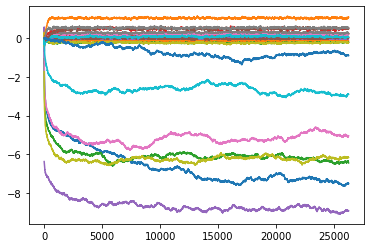

In [173]:
plt.plot(all_thetas)

In [31]:
q

21

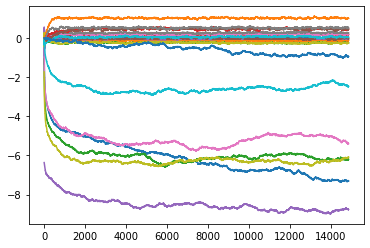

In [122]:
import matplotlib.pyplot as plt
plt.plot(all_thetas)
#plt.ylim(-3,-1)

In [ ]:
df = np.array(all_thetas)
#np.std(df[4000:], axis = 0)

In [ ]:
plt.plot(df[:,0:10])
#plt.plot(np.exp(0.5*df[:,10:20]))

In [ ]:
plt.plot(np.exp(0.5*df[:,10:20]))

In [ ]:
np.mean(acc)

In [ ]:
df = np.array(all_thetas)

In [ ]:
plt.plot(df[:,0:10])

In [ ]:
theta_hmc = np.mean(all_thetas[50:], axis = 0)
theta_hmc_sd = np.std(all_thetas[50:], axis = 0)
#np.save('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/all_thetas.npy', np.array(all_taus[J[1]:]))

In [ ]:
theta_hmc

In [ ]:
# comparison with VA

In [ ]:
vartheta_va = np.load('../../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts_delete.npy')

In [ ]:
vartheta_bts = np.load('../../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts_delete.npy')
vartheta_dts = np.load('../../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts_delete.npy')

In [ ]:
B_ts = np.mean(vartheta_bts[10000:, :,:], axis = 0)
d_ts = np.mean(vartheta_dts[10000:, :,:], axis = 0)
va_sd = np.sqrt(np.diag(B_ts.dot(B_ts.T) + d_ts**2))

In [ ]:
theta_va = np.mean(vartheta_va[10000:, :,:], axis = 0)

In [ ]:
plt.scatter(theta_va[0:10], theta_hmc[0:10])
#plt.scatter(theta_va[10:20], theta_hmc[10:20])
#plt.scatter(theta_va[20], theta_hmc[20])
ident = [-.5, .5]
plt.plot(ident,ident)

In [ ]:
beta_va = theta_hmc[0:10]

In [ ]:
theta_va[0:10]

In [ ]:
plt.scatter(va_sd[0:10], theta_hmc_sd[0:10])
plt.scatter(va_sd[10:20], theta_hmc_sd[10:20])
plt.scatter(va_sd[20], theta_hmc_sd[20])
ident = [0, 1.0]
plt.plot(ident,ident)